In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
#root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
root_path = '/home/jovyan/projects/skin/fetal_skin/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Cell-cell interactions in skin organoid: related to Hair follicle formation

In [4]:
#Load organoid CPDB summary files
org_path = root_path + 'cpdb/cpdb_organoid.tsv'
cpdb_org = pd.read_csv(org_path, delimiter="\t")
cpdb_org

,gene_pair,celltype_pair,mean,p,padj
0,FGF2|FGFR2,Adipocytes|Basal,0.282,0.000,0.000000
1,CD44|FGFR2,Adipocytes|Basal,0.627,0.000,0.000000
2,FGF7|FGFR2,Adipocytes|Basal,0.377,0.000,0.000000
3,TIMP1|FGFR2,Adipocytes|Basal,1.043,0.000,0.000000
4,FGFR1|FGFR2,Adipocytes|Basal,0.676,0.000,0.000000
...,...,...,...,...,...
20524,TNFSF12|TNFRSF12A,Tip cell (arterial)|Tip cell (arterial),0.242,0.005,0.079687
20525,CKLF|LRP6,Tip cell (arterial)|Tip cell (arterial),0.488,0.000,0.000000
20526,PROS1|TYRO3,Tip cell (arterial)|Tip cell (arterial),0.323,0.000,0.000000
20527,KITLG|KIT,Tip cell (arterial)|Tip cell (arterial),0.314,0.000,0.000000


In [5]:
cpdb_org.shape

(20529, 5)

In [6]:
# list of fibroblasts in data
#fib = ['Dermal condensate', 'Dermal papillia', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pre-dermal condensate', 'WNT2+ fibroblast']
fib = ['Dermal condensate', 'Dermal papillia', 'Early fibroblasts HOXC5', 'Fibroblasts POSTN+', 'Pre-dermal condensate']

In [7]:
#keratinocytes = ['Basal KC', 'Early KC (stem cell)', 'Hair follicle', 'Suprabasal']

In [8]:
# list of keratinocytes in data
keratinocytes_joint = ['Basal', 'Companion layer', 'Cuticle/cortex', 'Immature basal', 'Immature suprabasal', 'Inner root sheath', 'Outer root sheath',
                       'Basal POSTN+', 'Basal SHH+', 'Suprabasal IFE']

In [9]:
# list of HF fibroblasts in data
fib2 = ['Dermal condensate', 'Dermal papillia', 'Early fibroblasts HOXC5', 'Pre-dermal condensate']

In [10]:
# HF fibroblasts - early
fib4 = ['Early fibroblasts HOXC5', 'Pre-dermal condensate']

In [11]:
# HF fibroblasts - late
fib5 = ['Dermal condensate', 'Dermal papillia']

In [12]:
# obtain interactions for early HF fibroblasts
cpdb_fib6 = pd.DataFrame()
for i in fib4:
    print(i)
    temp = cpdb_org[(cpdb_org['celltype_pair'].str.startswith(i)) & (cpdb_org['celltype_pair'].str.contains('immature', case=False))]
    temp['Fibroblast'] = i
    temp['cell_pair'] = i + '_Epithelial_early'
    cpdb_fib6 = pd.concat([cpdb_fib6, temp])
cpdb_fib6

Early fibroblasts HOXC5
Pre-dermal condensate


,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
7437,CD44|FGFR2,Early fibroblasts HOXC5|Immature basal,0.468,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7438,FGF18|FGFR2,Early fibroblasts HOXC5|Immature basal,0.490,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7439,FGF7|FGFR2,Early fibroblasts HOXC5|Immature basal,0.613,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7440,TIMP1|FGFR2,Early fibroblasts HOXC5|Immature basal,0.716,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7441,FGFR1|FGFR2,Early fibroblasts HOXC5|Immature basal,0.888,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
...,...,...,...,...,...,...,...
17023,FGFR2|EPHA4,Pre-dermal condensate|Immature suprabasal,0.390,0.0,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
17024,EFNA4|EPHA4,Pre-dermal condensate|Immature suprabasal,0.289,0.0,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
17025,FGFR2|NECTIN1,Pre-dermal condensate|Immature suprabasal,0.329,0.0,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
17026,RSPO4|LGR4,Pre-dermal condensate|Immature suprabasal,0.132,0.0,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early


In [13]:
# remove Immature suprabasal/suprabasal IFE 
cpdb_fib6filt = cpdb_fib6[~ cpdb_fib6['celltype_pair'].str.contains('suprabasal', case=False)]
cpdb_fib6filt.shape

(51, 7)

In [14]:
# obtain interactions for late HF fibroblasts
cpdb_fib7 = pd.DataFrame()
for i in fib5:
    print(i)
    temp = cpdb_org[(cpdb_org['celltype_pair'].str.startswith(i)) & (cpdb_org['celltype_pair'].str.contains('basal|companion|cuticle|sheath', case=False))]
    temp['Fibroblast'] = i
    temp['cell_pair'] = i + '_Epithelial_late'
    cpdb_fib7 = pd.concat([cpdb_fib7, temp])
cpdb_fib7

Dermal condensate
Dermal papillia


,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
832,FAM3C|HLA-C,Dermal condensate|Basal,0.531,0.0,0.0,Dermal condensate,Dermal condensate_Epithelial_late
833,FAM3C|LAMP1,Dermal condensate|Basal,0.601,0.0,0.0,Dermal condensate,Dermal condensate_Epithelial_late
834,FAM3C|CXADR,Dermal condensate|Basal,0.868,0.0,0.0,Dermal condensate,Dermal condensate_Epithelial_late
835,TGFB1|EGFR,Dermal condensate|Basal,0.364,0.0,0.0,Dermal condensate,Dermal condensate_Epithelial_late
836,MIF|EGFR,Dermal condensate|Basal,0.812,0.0,0.0,Dermal condensate,Dermal condensate_Epithelial_late
...,...,...,...,...,...,...,...
19120,GRN|EGFR,Dermal papillia|Suprabasal IFE,0.397,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
19121,COPA|EGFR,Dermal papillia|Suprabasal IFE,0.407,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
19128,EFNB1|EPHB6,Dermal papillia|Suprabasal IFE,0.265,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
19129,WNT5A|FZD6,Dermal papillia|Suprabasal IFE,0.879,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late


In [15]:
# remove Immature suprabasal/suprabasal IFE and Immature basal
cpdb_fib7filt = cpdb_fib7[~ cpdb_fib7['celltype_pair'].str.contains('suprabasal|immature', case=False)]
cpdb_fib7filt.shape

(390, 7)

In [16]:
bind_fib2=[cpdb_fib6filt, cpdb_fib7filt]
cpdb_fib8 = pd.concat(bind_fib2)
cpdb_fib8

,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
7437,CD44|FGFR2,Early fibroblasts HOXC5|Immature basal,0.468,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7438,FGF18|FGFR2,Early fibroblasts HOXC5|Immature basal,0.490,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7439,FGF7|FGFR2,Early fibroblasts HOXC5|Immature basal,0.613,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7440,TIMP1|FGFR2,Early fibroblasts HOXC5|Immature basal,0.716,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
7441,FGFR1|FGFR2,Early fibroblasts HOXC5|Immature basal,0.888,0.0,0.0,Early fibroblasts HOXC5,Early fibroblasts HOXC5_Epithelial_early
...,...,...,...,...,...,...,...
15670,COPA|EGFR,Dermal papillia|Outer root sheath,0.506,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
15671,VEGFB|NRP1,Dermal papillia|Outer root sheath,0.409,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
15676,EFNB1|EPHB6,Dermal papillia|Outer root sheath,0.468,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
15677,WNT5A|FZD6,Dermal papillia|Outer root sheath,0.982,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late


In [17]:
print(cpdb_fib8['celltype_pair'].unique())

['Early fibroblasts HOXC5|Immature basal' 'Pre-dermal condensate|Immature basal' 'Dermal condensate|Basal' 'Dermal condensate|Basal POSTN+'
 'Dermal condensate|Basal SHH+' 'Dermal condensate|Companion layer' 'Dermal condensate|Cuticle/cortex' 'Dermal condensate|Inner root sheath'
 'Dermal condensate|Outer root sheath' 'Dermal papillia|Basal' 'Dermal papillia|Basal POSTN+' 'Dermal papillia|Basal SHH+'
 'Dermal papillia|Companion layer' 'Dermal papillia|Cuticle/cortex' 'Dermal papillia|Inner root sheath' 'Dermal papillia|Outer root sheath']


In [18]:
print(cpdb_fib8['cell_pair'].unique())

['Early fibroblasts HOXC5_Epithelial_early' 'Pre-dermal condensate_Epithelial_early' 'Dermal condensate_Epithelial_late'
 'Dermal papillia_Epithelial_late']


In [19]:
# grouby gene_pair/cell_pair and compute mean of interaction means
array_fib8 = cpdb_fib8.groupby(['gene_pair', 'cell_pair'])['mean'].mean().to_frame(name='new_mean').reset_index()
array_fib8

,gene_pair,cell_pair,new_mean
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.1340
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.5908
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.6340
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.6344
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.4680
...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.3320
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.2600
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.2834
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.8614


In [20]:
# find min adjusted p-value for each combination of gene_pair-cell_pair
gene_pair = list(array_fib8['gene_pair'])
cell_pair = list(array_fib8['cell_pair'])
cpdb_fib8_p = cpdb_fib8.loc[(cpdb_fib8['gene_pair'].isin(gene_pair)) & (cpdb_fib8['cell_pair'].isin(cell_pair))]
cpdb_fib8_p = cpdb_fib8_p.groupby(['gene_pair', 'cell_pair'])['padj'].min().to_frame(name='min_padj').reset_index()
cpdb_fib8_p

,gene_pair,cell_pair,min_padj
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.0
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.0
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.0
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.0
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.0
...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.0
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.0
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.0
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.0


In [21]:
# add min adlisted p-value to means dataframe
gene_pair2 = list(cpdb_fib8_p['gene_pair'])
cell_pair2 = list(cpdb_fib8_p['cell_pair'])
array_fib8.loc[(array_fib8['gene_pair'].isin(gene_pair2)) & (array_fib8['cell_pair'].isin(cell_pair2)), 'min_padj'] = cpdb_fib8_p['min_padj']
array_fib8

,gene_pair,cell_pair,new_mean,min_padj
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.1340,0.0
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.5908,0.0
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.6340,0.0
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.6344,0.0
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.4680,0.0
...,...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.3320,0.0
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.2600,0.0
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.2834,0.0
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.8614,0.0


In [22]:
# filter to min adjusted p-value <0.05
array_fib8 = array_fib8[array_fib8['min_padj'] < 0.05]
array_fib8

,gene_pair,cell_pair,new_mean,min_padj
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.1340,0.0
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.5908,0.0
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.6340,0.0
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.6344,0.0
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.4680,0.0
...,...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.3320,0.0
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.2600,0.0
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.2834,0.0
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.8614,0.0


In [23]:
array_fib8['Fibroblast'] = [x.split('_')[0] for x in array_fib8['cell_pair']]
array_fib8

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.1340,0.0,Pre-dermal condensate
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.5908,0.0,Dermal papillia
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.6340,0.0,Dermal condensate
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.6344,0.0,Dermal papillia
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.4680,0.0,Early fibroblasts HOXC5
...,...,...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.3320,0.0,Early fibroblasts HOXC5
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.2600,0.0,Pre-dermal condensate
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.2834,0.0,Dermal condensate
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.8614,0.0,Dermal papillia


In [24]:
# obtain top 10 interactions per cell pair
array_fib8_top = array_fib8.groupby('cell_pair').apply(lambda grp: grp.nlargest(10, 'new_mean')).reset_index(drop=True)
array_fib8_top

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,MIF|EGFR,Dermal condensate_Epithelial_late,0.852429,0.0,Dermal condensate
1,FAM3C|CXADR,Dermal condensate_Epithelial_late,0.839857,0.0,Dermal condensate
2,TIMP1|FGFR2,Dermal condensate_Epithelial_late,0.799571,0.0,Dermal condensate
3,MDK|SORL1,Dermal condensate_Epithelial_late,0.799500,0.0,Dermal condensate
4,FGFR1|FGFR2,Dermal condensate_Epithelial_late,0.774000,0.0,Dermal condensate
5,VEGFA|NRP2,Dermal condensate_Epithelial_late,0.745500,0.0,Dermal condensate
6,FAM3C|LAMP1,Dermal condensate_Epithelial_late,0.704571,0.0,Dermal condensate
7,CD44|FGFR2,Dermal condensate_Epithelial_late,0.634000,0.0,Dermal condensate
8,PGF|NRP2,Dermal condensate_Epithelial_late,0.576250,0.0,Dermal condensate
9,COPA|EGFR,Dermal condensate_Epithelial_late,0.547143,0.0,Dermal condensate


In [25]:
# sort cell_pairs
sorter = ['Early fibroblasts HOXC5_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
sorterIndex = dict(zip(sorter, range(len(sorter))))
array_fib8_top['cell_pair_Rank'] = array_fib8_top['cell_pair'].map(sorterIndex)
array_fib8_top.sort_values(['cell_pair_Rank', 'new_mean'],ascending = [True, False], inplace = True)
array_fib8_top.drop('cell_pair_Rank', 1, inplace = True)
array_fib8_top

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
20,MDK|LRP1,Early fibroblasts HOXC5_Epithelial_early,1.224000,0.0,Early fibroblasts HOXC5
21,FGFR1|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.888000,0.0,Early fibroblasts HOXC5
22,TIMP1|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.716000,0.0,Early fibroblasts HOXC5
23,CXCL12|ACKR3,Early fibroblasts HOXC5_Epithelial_early,0.657000,0.0,Early fibroblasts HOXC5
24,FGF7|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.613000,0.0,Early fibroblasts HOXC5
25,FGF18|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.490000,0.0,Early fibroblasts HOXC5
26,COPA|EGFR,Early fibroblasts HOXC5_Epithelial_early,0.480000,0.0,Early fibroblasts HOXC5
27,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.468000,0.0,Early fibroblasts HOXC5
28,RSPO3|LGR4,Early fibroblasts HOXC5_Epithelial_early,0.436000,0.0,Early fibroblasts HOXC5
29,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.332000,0.0,Early fibroblasts HOXC5


In [26]:
array_fib8_plot = array_fib8_top.pivot_table(index='gene_pair', columns='cell_pair', values='new_mean', sort=False)

In [27]:
column_order = ['Early fibroblasts HOXC5_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
array_fib8_plot = array_fib8_plot.replace(np.nan, 0) # copy df but with nans as 0
array_fib8_plot = array_fib8_plot[column_order] # reorder columns to correct order (x axis)

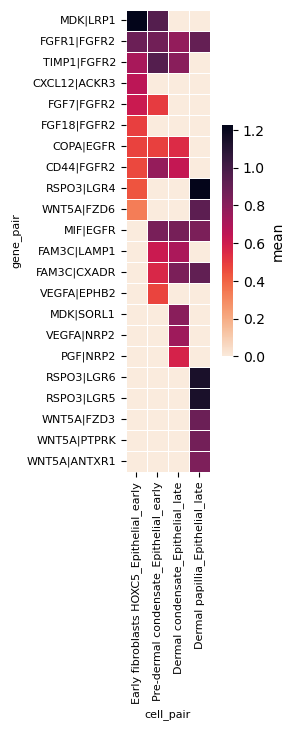

In [29]:
# Plot - organoid top 10
plt.subplots(figsize=(3,6))
ax = sn.heatmap(array_fib8_plot, cmap='rocket_r', linewidths=0.5, linecolor='white', square = True, annot=False, xticklabels=1, yticklabels=1, cbar_kws={"shrink": 0.5, 'label':'mean'})
for i in [plt.xticks, plt.yticks]:
    i(fontsize=8) 
for i in [ax.xaxis.label.set_size, ax.yaxis.label.set_size]:
    i(8)
plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/CPDB_top10_organoid.pdf',dpi=300, bbox_inches = "tight")

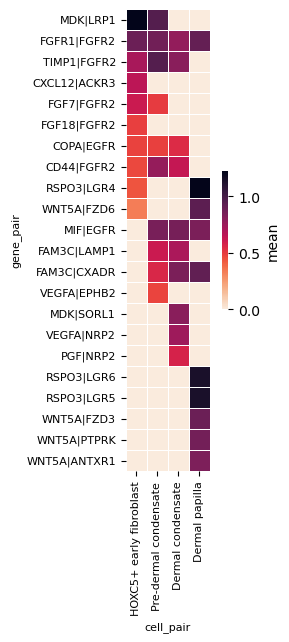

In [29]:
plt.subplots(figsize=(3,6))
ax = sn.heatmap(array_fib8_plot, cmap='rocket_r', linewidths=0.5, linecolor='white', square = True, 
                 annot=False, xticklabels=['HOXC5+ early fibroblast', 'Pre-dermal condensate', 'Dermal condensate','Dermal papilla'], yticklabels=1, cbar_kws={"shrink": 0.3, 'label':'mean'})
for i in [plt.xticks, plt.yticks]:
    i(fontsize=8) 
for i in [ax.xaxis.label.set_size, ax.yaxis.label.set_size]:
    i(8)
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/CPDB_10_23102022_v2.pdf',dpi=300, bbox_inches = "tight")

# Subset to interactions in common with FS (top 10)

In [30]:
array_fib8

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.1340,0.0,Pre-dermal condensate
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.5908,0.0,Dermal papillia
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.6340,0.0,Dermal condensate
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.6344,0.0,Dermal papillia
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.4680,0.0,Early fibroblasts HOXC5
...,...,...,...,...,...
130,WNT5A|FZD6,Early fibroblasts HOXC5_Epithelial_early,0.3320,0.0,Early fibroblasts HOXC5
131,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.2600,0.0,Pre-dermal condensate
132,WNT5A|PTPRK,Dermal condensate_Epithelial_late,0.2834,0.0,Dermal condensate
133,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.8614,0.0,Dermal papillia


In [31]:
list(array_fib8['gene_pair'].unique())

['BDNF|F11R',
 'BMP7|PTPRK',
 'CD44|FGFR2',
 'COPA|EGFR',
 'COPA|SORT1',
 'CXCL12|ACKR3',
 'CXCL12|DPP4',
 'EFNA4|EPHA1',
 'EFNA4|EPHA2',
 'EFNA4|EPHA4',
 'EFNB1|EPHB6',
 'FAM3C|CLEC2D',
 'FAM3C|CXADR',
 'FAM3C|HLA-C',
 'FAM3C|LAMP1',
 'FGF18|FGFR2',
 'FGF18|FGFR3',
 'FGF7|FGFR2',
 'FGF7|FGFR3',
 'FGFR1|FGFR2',
 'FGFR2|CD83',
 'FGFR2|EPHA4',
 'FGFR2|FGFR3',
 'FGFR2|NECTIN1',
 'FGFR2|XPR1',
 'FGFR3|EPHA4',
 'FGFR3|NECTIN1',
 'GRN|EGFR',
 'GRN|SORT1',
 'IGF1|IGF1R',
 'MDK|LRP1',
 'MDK|SORL1',
 'MIF|EGFR',
 'NECTIN3|NECTIN1',
 'PGF|NRP2',
 'PSAP|GPR37',
 'RSPO1|LGR4',
 'RSPO1|LGR5',
 'RSPO1|LGR6',
 'RSPO3|LGR4',
 'RSPO3|LGR5',
 'RSPO3|LGR6',
 'RSPO4|LGR4',
 'TGFB1|EGFR',
 'TGFB2|TGFBR3',
 'TIMP1|FGFR2',
 'TNFSF12|TNFRSF12A',
 'TNFSF12|TNFRSF25',
 'VEGFA|EPHB2',
 'VEGFA|NRP2',
 'VEGFB|NRP1',
 'WNT5A|ANTXR1',
 'WNT5A|FZD1',
 'WNT5A|FZD3',
 'WNT5A|FZD6',
 'WNT5A|PTPRK']

In [32]:
# keep only interactions present in FS plot (top 10)
# see Figure 2i - CPDB interactions in prenatal skin related to HF formation
gene_pair_keep = ['MDK|LRP1',
 'FGFR1|FGFR2',
 'TIMP1|FGFR2',
 'CD44|FGFR2',                
 'CXCL12|ACKR3',               
 'GRN|EGFR',   
 'COPA|EGFR',                  
 'FAM3C|CXADR',             
 'FAM3C|LAMP1',
 'TGFB1|EGFR',  
 'MIF|EGFR',
 'MDK|SORL1',
 'EFNB1|EPHB6',
 'RSPO3|LGR5',
 'RSPO3|LGR6',
 'RSPO3|LGR4',
 'BMP7|PTPRK',
 'VEGFA|NRP2']

#missing in organoid compared to FS: 
#'IGF2|IGF1R',
#'EPHB6|EFNB2',
#'FAM3C|PDCD1',

In [33]:
array_fib8_filtered = array_fib8[array_fib8['gene_pair'].isin(gene_pair_keep)]
array_fib8_filtered

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
1,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.590800,0.0,Dermal papillia
2,CD44|FGFR2,Dermal condensate_Epithelial_late,0.634000,0.0,Dermal condensate
3,CD44|FGFR2,Dermal papillia_Epithelial_late,0.634400,0.0,Dermal papillia
4,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.468000,0.0,Early fibroblasts HOXC5
5,CD44|FGFR2,Pre-dermal condensate_Epithelial_early,0.767000,0.0,Pre-dermal condensate
7,COPA|EGFR,Dermal condensate_Epithelial_late,0.547143,0.0,Dermal condensate
8,COPA|EGFR,Dermal papillia_Epithelial_late,0.510429,0.0,Dermal papillia
9,COPA|EGFR,Early fibroblasts HOXC5_Epithelial_early,0.480000,0.0,Early fibroblasts HOXC5
10,COPA|EGFR,Pre-dermal condensate_Epithelial_early,0.487000,0.0,Pre-dermal condensate
13,CXCL12|ACKR3,Dermal condensate_Epithelial_late,0.339500,0.0,Dermal condensate


In [34]:
# Add missing interactions to create equivalent plot with mean value 0

missing_df = pd.DataFrame({'gene_pair': ['IGF2|IGF1R','EPHB6|EFNB2','FAM3C|PDCD1'],
                   'cell_pair': ['Early fibroblasts HOXC5_Epithelial early', 'Early fibroblasts HOXC5_Epithelial early', 'Dermal condensate_Epithelial late'],
                   'new_mean': [0, 0, 0],
                   'min_padj': [0, 0, 0],
                   'Fibroblast': ['Early fibroblasts HOXC5','Early fibroblasts HOXC5','Dermal condensate']})
missing_df

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,IGF2|IGF1R,Early fibroblasts HOXC5_Epithelial early,0,0,Early fibroblasts HOXC5
1,EPHB6|EFNB2,Early fibroblasts HOXC5_Epithelial early,0,0,Early fibroblasts HOXC5
2,FAM3C|PDCD1,Dermal condensate_Epithelial late,0,0,Dermal condensate


In [35]:
array_fib8_filtered = array_fib8_filtered.append(missing_df, ignore_index=True)
array_fib8_filtered

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.590800,0.0,Dermal papillia
1,CD44|FGFR2,Dermal condensate_Epithelial_late,0.634000,0.0,Dermal condensate
2,CD44|FGFR2,Dermal papillia_Epithelial_late,0.634400,0.0,Dermal papillia
3,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.468000,0.0,Early fibroblasts HOXC5
4,CD44|FGFR2,Pre-dermal condensate_Epithelial_early,0.767000,0.0,Pre-dermal condensate
5,COPA|EGFR,Dermal condensate_Epithelial_late,0.547143,0.0,Dermal condensate
6,COPA|EGFR,Dermal papillia_Epithelial_late,0.510429,0.0,Dermal papillia
7,COPA|EGFR,Early fibroblasts HOXC5_Epithelial_early,0.480000,0.0,Early fibroblasts HOXC5
8,COPA|EGFR,Pre-dermal condensate_Epithelial_early,0.487000,0.0,Pre-dermal condensate
9,CXCL12|ACKR3,Dermal condensate_Epithelial_late,0.339500,0.0,Dermal condensate


In [41]:
#skip
#sorter = ['Early fibroblasts HOXC5_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
#sorterIndex = dict(zip(sorter, range(len(sorter))))
#array_fib8_filtered['cell_pair_Rank'] = array_fib8_filtered['cell_pair'].map(sorterIndex)
#array_fib8_filtered.sort_values(['cell_pair_Rank'],ascending = [True], inplace = True)
#array_fib8_filtered.drop('cell_pair_Rank', 1, inplace = True)
#array_fib8_filtered

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
3,CD44|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.468000,0.0,Early fibroblasts HOXC5
27,MDK|LRP1,Early fibroblasts HOXC5_Epithelial_early,1.224000,0.0,Early fibroblasts HOXC5
44,TIMP1|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.716000,0.0,Early fibroblasts HOXC5
7,COPA|EGFR,Early fibroblasts HOXC5_Epithelial_early,0.480000,0.0,Early fibroblasts HOXC5
22,FGFR1|FGFR2,Early fibroblasts HOXC5_Epithelial_early,0.888000,0.0,Early fibroblasts HOXC5
40,TGFB1|EGFR,Early fibroblasts HOXC5_Epithelial_early,0.260000,0.0,Early fibroblasts HOXC5
10,CXCL12|ACKR3,Early fibroblasts HOXC5_Epithelial_early,0.657000,0.0,Early fibroblasts HOXC5
34,RSPO3|LGR4,Early fibroblasts HOXC5_Epithelial_early,0.436000,0.0,Early fibroblasts HOXC5
23,FGFR1|FGFR2,Pre-dermal condensate_Epithelial_early,0.868000,0.0,Pre-dermal condensate
32,MIF|EGFR,Pre-dermal condensate_Epithelial_early,0.851000,0.0,Pre-dermal condensate


In [36]:
array_fib8_plot_filtered = array_fib8_filtered.pivot_table(index='gene_pair', columns='cell_pair', values='new_mean', sort=False)
#array_fib8_plot_filtered

In [37]:
index_order = ['MDK|LRP1',
 'FGFR1|FGFR2',
 'TIMP1|FGFR2',
 'CD44|FGFR2',                
 'CXCL12|ACKR3',
 'IGF2|IGF1R',
 'GRN|EGFR',   
 'COPA|EGFR',                  
 'FAM3C|CXADR',
 'EPHB6|EFNB2',
 'FAM3C|LAMP1',
 'TGFB1|EGFR',  
 'MIF|EGFR',
 'MDK|SORL1',
 'EFNB1|EPHB6',
 'FAM3C|PDCD1',
 'RSPO3|LGR5',
 'RSPO3|LGR6',
 'RSPO3|LGR4',
 'BMP7|PTPRK',
 'VEGFA|NRP2']

array_fib8_plot_filtered = array_fib8_plot_filtered.loc[index_order]
#gene_sorterIndex = dict(zip(gene_sorter, range(len(gene_sorter))))
#array_fib8_plot_filtered['cell_pair_Rank'] = array_fib8_plot_filtered['gene_pair'].map(gene_sorterIndex)
#array_fib8_plot_filtered.sort_values(['cell_pair_Rank'],ascending = [True], inplace = True)
#array_fib8_plot_filtered.drop('cell_pair_Rank', 1, inplace = True)

In [38]:
column_order = ['Early fibroblasts HOXC5_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
array_fib8_plot_filtered = array_fib8_plot_filtered.replace(np.nan, 0) # copy df but with nans as 0
array_fib8_plot_filtered = array_fib8_plot_filtered[column_order] # reorder columns to correct order (x axis)
array_fib8_plot_filtered

cell_pair,Early fibroblasts HOXC5_Epithelial_early,Pre-dermal condensate_Epithelial_early,Dermal condensate_Epithelial_late,Dermal papillia_Epithelial_late
gene_pair,,,,
MDK|LRP1,1.224,0.955,0.000000,0.000000
FGFR1|FGFR2,0.888,0.868,0.774000,0.907143
TIMP1|FGFR2,0.716,0.952,0.799571,0.716400
CD44|FGFR2,0.468,0.767,0.634000,0.634400
CXCL12|ACKR3,0.657,0.398,0.339500,0.000000
IGF2|IGF1R,0.000,0.000,0.000000,0.000000
GRN|EGFR,0.000,0.396,0.496571,0.500429
COPA|EGFR,0.480,0.487,0.547143,0.510429
FAM3C|CXADR,0.000,0.561,0.839857,0.913571


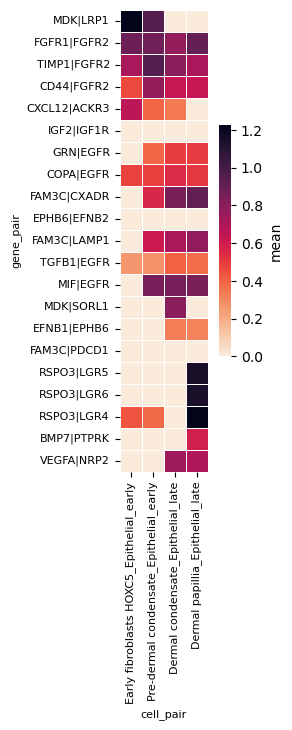

In [39]:
# Plot - organoid
plt.subplots(figsize=(3,6))
ax = sn.heatmap(array_fib8_plot_filtered, cmap='rocket_r', linewidths=0.5, linecolor='white', square = True, annot=False, xticklabels=1, yticklabels=1, cbar_kws={"shrink": 0.5, 'label':'mean'})
for i in [plt.xticks, plt.yticks]:
    i(fontsize=8) 
for i in [ax.xaxis.label.set_size, ax.yaxis.label.set_size]:
    i(8)
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/CPDB_org_27062023.pdf',dpi=300, bbox_inches = "tight")